In [1]:
# ライブラリインポート

## 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 分解
import scipy.stats
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
import my_function

## 学習
from esn_model import ESN, Tikhonov
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# データ読み込み

## csv読み込み
df = pd.read_csv('./available_csv/AirPassengers.csv')
print(df.head())

## データ整形（必要であれば）
df = df['Passengers']
print(df.head())

        Month  Passengers
0  1949-01-01         112
1  1949-02-01         118
2  1949-03-01         132
3  1949-04-01         129
4  1949-05-01         121
0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64


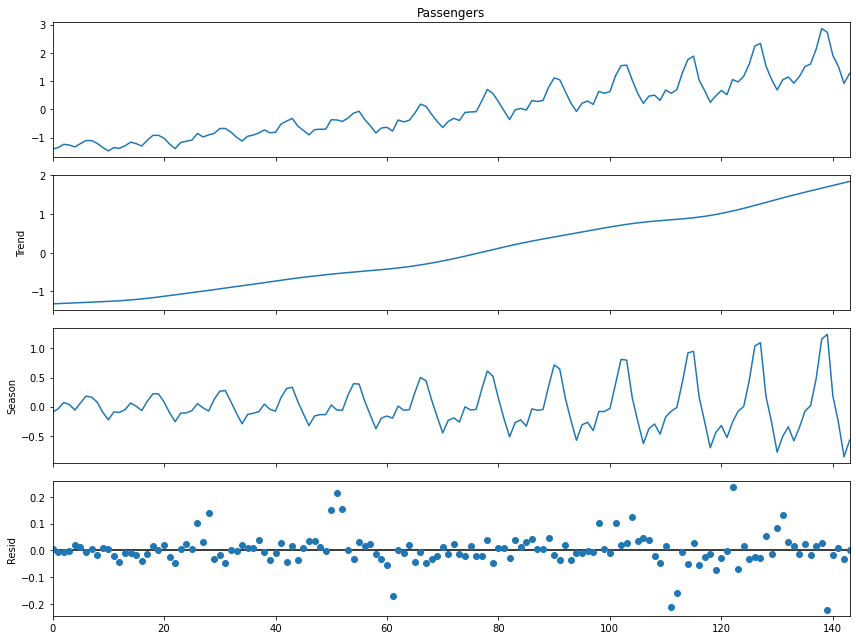

In [3]:
# 分解

## 正規化
raw_array = scipy.stats.zscore(df)

## STL分解
stl=STL(raw_array, period=12, robust=True)
stl_series = stl.fit()

## STL分解結果のグラフ化
plt.rcParams['figure.figsize'] = [12, 9]
stl_series.plot()
plt.show()

## データの整形
### default : SlideingWindow = 5
raw_x, raw_y = my_function.sliding_window(raw_array)
trend_x, trend_y = my_function.sliding_window(stl_series.trend)
seasonal_x, seasonal_y = my_function.sliding_window(stl_series.seasonal)
resid_x, resid_y = my_function.sliding_window(stl_series.resid)

## データの分割
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=False)
trend_x_train, trend_x_test, trend_y_train, trend_y_test = train_test_split(trend_x, trend_y, test_size=0.1, shuffle=False)
seasonal_x_train, seasonal_x_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_x, seasonal_y, test_size=0.1, shuffle=False)
resid_x_train, resid_x_test, resid_y_train, resid_y_test = train_test_split(resid_x, resid_y, test_size=0.1, shuffle=False)

In [30]:
# 学習

## ハイパーパラメータ
N_x = 300

## 単体学習
### トレンド学習
trend_esn_model = ESN(trend_x_train.shape[1], 1, N_x, density=0.05, input_scale=1.0, rho=0.8, leaking_rate=1.0)
trend_esn_model.train(trend_x_train, raw_y_train, Tikhonov(N_x, 1, 0.0))
### 季節性学習
seasonal_reg = DecisionTreeRegressor()
seasonal_cart_model = seasonal_reg.fit(seasonal_x_train, raw_y_train)
### 残差学習
resid_reg = DecisionTreeRegressor()
resid_cart_model = resid_reg.fit(resid_x_train, raw_y_train)

## 結合学習
### 重回帰用のデータフレームの作成
lr_np_train = np.concatenate([trend_esn_model.predict(trend_x_train),
                    seasonal_cart_model.predict(seasonal_x_train).reshape(-1, 1),
                    resid_cart_model.predict(resid_x_train).reshape(-1, 1)], 1)
lr_df_train = pd.DataFrame(lr_np_train)
### 重回帰分析
lr_model = LinearRegression()
lr_model.fit(lr_df_train, raw_y_train)
lr_pred_train = lr_model.predict(lr_df_train)

In [33]:
# 予測

## 単体予測
trend_esn_pred = trend_esn_model.predict(trend_x_test)
seasonal_cart_pred = seasonal_cart_model.predict(seasonal_x_test).reshape(-1, 1)
resid_cart_pred = resid_cart_model.predict(resid_x_test).reshape(-1, 1)

## 結合予測
lr_np_test = np.concatenate([trend_esn_pred,
                            seasonal_cart_pred,
                            resid_cart_pred], 1)
lr_df_test = pd.DataFrame(lr_np_test)
lr_pred_test = lr_model.predict(lr_df_test)

In [34]:
# 評価
lr_pred_test

array([0.11042656, 0.75451369, 0.11879132, 0.10206179, 0.91762667,
       0.47429396, 0.40319344, 0.74614893, 1.07237488, 0.65413648,
       0.4115582 , 1.17693448, 1.06401011, 0.16897993])